In [240]:
import json
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
# import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset, ConcatDataset
from cgm_pp_helpers import read_cgm_data, CGMDataPipeline

L = ['Breakfast Calories','Lunch Calories','Breakfast Carbs','Lunch Carbs','Breakfast Fat','Lunch Fat','Breakfast Protein','Lunch Protein']
LABELS = 8 # 2,4,8
DELTA = 1 # 0,1,2

def aggs(cgm):
    pp = CGMDataPipeline()
    cgm_train_features = pp.fit_transform(read_cgm_data(cgm))
    cgm_features = [
    'Subject ID', 
    'Day', 
    'Breakfast_mean', 
    'Breakfast_std', 
    'Breakfast_min', 
    'Breakfast_max',
    'Breakfast_median',
    'Breakfast_range',
    'Breakfast_auc', 
    'Breakfast_rate_of_change',
    'Breakfast_skewness',
    'Breakfast_kurtosis'
    ]
    return cgm_train_features[cgm_features]

def datacsv2dl(img,cgm,viome,lbl):
    class dataset(Dataset):
        def __init__(self, data, labels):
            self.data = data
            self.labels = labels

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            d = torch.tensor(self.data.iloc[idx][self.data.columns.difference(['Subject ID','Day'])])
            label = torch.tensor(self.labels.iloc[idx][self.labels.difference(['Subject ID','Day'])], dtype=torch.int32)
            return d, label
    
    img_data = pd.read_csv(img)
    img_data['Image Before Breakfast'] = img_data['Image Before Breakfast'].apply(ast.literal_eval).apply(np.array)
    img_data['Image Before Lunch'] = img_data['Image Before Lunch'].apply(ast.literal_eval).apply(np.array)

    cgm_data = pd.read_csv(cgm)
    cgm_data['Breakfast Time'] = pd.to_datetime(cgm_data['Breakfast Time'], errors='coerce')
    cgm_data['Lunch Time'] = pd.to_datetime(cgm_data['Lunch Time'], errors='coerce')
    cgm_data['CGM Data'] = cgm_data['CGM Data'].apply(ast.literal_eval)
    for _, row in cgm_data.iterrows():
        for i, t in enumerate(row['CGM Data']):
            row['CGM Data'][i] = (datetime.strptime(t[0], '%Y-%m-%d %H:%M:%S').timestamp(), t[1:])

    viome_data = pd.read_csv(viome)
    viome_data['Viome'] = viome_data['Viome'].apply(ast.literal_eval).apply(np.array)

    data = img_data.merge(cgm_data, on=['Subject ID','Day'])
    data = data.merge(viome_data, on=['Subject ID'])

    labels = pd.read_csv(lbl)
    if lbl[-8:]=='only.csv':
        labels = data.merge(labels, on=['Subject ID','Day'])[['Breakfast Calories','Breakfast Carbs','Breakfast Fat','Breakfast Protein']]
    else:
        labels = data.merge(labels, on=['Subject ID','Day'])[['Breakfast Calories','Lunch Calories','Breakfast Carbs','Lunch Carbs','Breakfast Fat','Lunch Fat','Breakfast Protein','Lunch Protein']]
    
    ds = dataset(data,labels)
    return DataLoader(ds, batch_size=32, shuffle=True)

def HM(dt):
    return dt.hour * 60 + dt.minute

def time_only_mean(series):
        """Compute the average time ignoring the date."""
        times = series.dropna().dt.time
        if times.empty:
            return None
        total_seconds = [t.hour * 3600 + t.minute * 60 + t.second + t.microsecond / 1e6 for t in times]
        avg_seconds = sum(total_seconds) / len(total_seconds)
        avg_time = (datetime.min + timedelta(seconds=avg_seconds)).time()
        return avg_time

def datacsv2ndarry_cgm(cgm,viome,lbl):
    # img_data = pd.read_csv(img)
    # img_data['Image Before Breakfast'] = img_data['Image Before Breakfast'].apply(ast.literal_eval).apply(np.array)
    # img_data['Image Before Lunch'] = img_data['Image Before Lunch'].apply(ast.literal_eval).apply(np.array)

    cgm_data = pd.read_csv(cgm)
    cgm_data['CGM Data'] = cgm_data['CGM Data'].apply(ast.literal_eval)
    cgm_data['Breakfast Time'] = pd.to_datetime(cgm_data['Breakfast Time'], errors='coerce')
    cgm_data['Lunch Time'] = pd.to_datetime(cgm_data['Lunch Time'], errors='coerce')
    cgm_data.dropna(subset=['CGM Data'],inplace=True)
    cgm_data = cgm_data[cgm_data['CGM Data'].map(len)>0]
    
    # Compute averages per person (HH:mm:ss only)
    averages = cgm_data.groupby("Subject ID").agg(
        avg_breakfast=("Breakfast Time", time_only_mean),
        avg_lunch=("Lunch Time", time_only_mean)
    )
    # cgm_data['Breakfast Time'] = cgm_data['Breakfast Time'].apply(HM)
    # cgm_data['Lunch Time'] = cgm_data['Lunch Time'].apply(HM)

    # Fill missing times with subject-specific averages
    def fill_with_avg(row, column, avg_column):
        if pd.isnull(row[column]):
            avg_time = averages.loc[row["Subject ID"], avg_column]
            if avg_time:
                # Extract the day from CGM Data
                cgm = row["CGM Data"]
                # print(cgm)
                first_timestamp_str = cgm[0][0]  # e.g., '2021-09-19 08:20:00'
                day = first_timestamp_str.split(" ")[0]
                # Combine date and time directly
                return datetime.combine(datetime.strptime(day, "%Y-%m-%d").date(), avg_time)
        return row[column]

    cgm_data["Breakfast Time"] = cgm_data.apply(lambda row: fill_with_avg(row, "Breakfast Time", "avg_breakfast"), axis=1).apply(HM)
    cgm_data["Lunch Time"] = cgm_data.apply(lambda row: fill_with_avg(row, "Lunch Time", "avg_lunch"), axis=1).apply(HM)
    
    for j, row in cgm_data.iterrows():
        if cgm_data.at[j, 'CGM Data']==[]:
            cgm_data.drop(j, inplace=True)
            continue
        # print(j)
        # try:
        # cgm_data.at[j, 'Breakfast Time'] = HM(row['Breakfast Time'])
        # cgm_data.at[j, 'Lunch Time'] = HM(row['Lunch Time'])
        for i, t in enumerate(row['CGM Data']):
            row['CGM Data'][i] = [HM(datetime.strptime(t[0], '%Y-%m-%d %H:%M:%S')), t[1]]
        # except:
        #     cgm_data.drop(j, inplace=True)

    viome_data = pd.read_csv(viome)
    # viome_data['Viome'] = viome_data['Viome'].apply(ast.literal_eval).apply(np.array)

    data = cgm_data.merge(viome_data, on=['Subject ID'])

    labels = pd.read_csv(lbl)
    if lbl[-8:]=='only.csv':
        labels = data.merge(labels, on=['Subject ID','Day'])[['Breakfast Calories','Breakfast Carbs','Breakfast Fat','Breakfast Protein']]
        labels = labels[[label for i,label in enumerate(L[:LABELS]) if i%2==0]] # only pull breakfast columns from test file
        print(f'Label Columns: {labels.columns}')
    else:
        labels = data.merge(labels, on=['Subject ID','Day'])[['Breakfast Calories','Lunch Calories','Breakfast Carbs','Lunch Carbs','Breakfast Fat','Lunch Fat','Breakfast Protein','Lunch Protein']]
        labels = labels[L[:LABELS]]
        print(f'Label Columns: {labels.columns}')
    data = data[['Breakfast Time','Lunch Time','CGM Data','Diabetes Status','A1C']]
    print(f'Data Columns: {data.columns}')
    
    return np.array(data), np.array(labels)

def datacsv2ndarry_cgm_delta(cgm,viome,lbl):
    # img_data = pd.read_csv(img)
    # img_data['Image Before Breakfast'] = img_data['Image Before Breakfast'].apply(ast.literal_eval).apply(np.array)
    # img_data['Image Before Lunch'] = img_data['Image Before Lunch'].apply(ast.literal_eval).apply(np.array)

    cgm_data = pd.read_csv(cgm)
    cgm_data['CGM Data'] = cgm_data['CGM Data'].apply(ast.literal_eval)
    cgm_data['Breakfast Time'] = pd.to_datetime(cgm_data['Breakfast Time'], errors='coerce')
    cgm_data['Lunch Time'] = pd.to_datetime(cgm_data['Lunch Time'], errors='coerce')
    cgm_data.dropna(subset=['CGM Data'],inplace=True)
    cgm_data = cgm_data[cgm_data['CGM Data'].map(len)>0]
    
    # Compute averages per person (HH:mm:ss only)
    averages = cgm_data.groupby("Subject ID").agg(
        avg_breakfast=("Breakfast Time", time_only_mean),
        avg_lunch=("Lunch Time", time_only_mean)
    )
    # cgm_data['Breakfast Time'] = cgm_data['Breakfast Time'].apply(HM)
    # cgm_data['Lunch Time'] = cgm_data['Lunch Time'].apply(HM)

    # Fill missing times with subject-specific averages
    def fill_with_avg(row, column, avg_column):
        if pd.isnull(row[column]):
            avg_time = averages.loc[row["Subject ID"], avg_column]
            if avg_time:
                # Extract the day from CGM Data
                cgm = row["CGM Data"]
                # print(cgm)
                first_timestamp_str = cgm[0][0]  # e.g., '2021-09-19 08:20:00'
                day = first_timestamp_str.split(" ")[0]
                # Combine date and time directly
                return datetime.combine(datetime.strptime(day, "%Y-%m-%d").date(), avg_time)
        return row[column]

    cgm_data["Breakfast Time"] = cgm_data.apply(lambda row: fill_with_avg(row, "Breakfast Time", "avg_breakfast"), axis=1).apply(HM)
    cgm_data["Lunch Time"] = cgm_data.apply(lambda row: fill_with_avg(row, "Lunch Time", "avg_lunch"), axis=1).apply(HM)
    
    for j, row in cgm_data.iterrows():
        if cgm_data.at[j, 'CGM Data']==[]:
            cgm_data.drop(j, inplace=True)
            continue
        # print(j)
        # try:
        # cgm_data.at[j, 'Breakfast Time'] = HM(row['Breakfast Time'])
        # cgm_data.at[j, 'Lunch Time'] = HM(row['Lunch Time'])
        for i, t in enumerate(row['CGM Data']):
            row['CGM Data'][i] = [HM(datetime.strptime(t[0], '%Y-%m-%d %H:%M:%S')), t[1]]
        # except:
        #     cgm_data.drop(j, inplace=True)

    if DELTA>0:
        cgm_data['CGM Shift'] = cgm_data.groupby('Subject ID')['CGM Data'].shift(-DELTA)
        cgm_data = cgm_data.dropna(subset=['CGM Shift'])
        cgm_data['CGM Data'] = cgm_data['CGM Shift']

    viome_data = pd.read_csv(viome)
    # viome_data['Viome'] = viome_data['Viome'].apply(ast.literal_eval).apply(np.array)

    cgm_data = cgm_data.merge(aggs(cgm), on=['Subject ID','Day'])
    data = cgm_data.merge(viome_data, on=['Subject ID'])

    labels = pd.read_csv(lbl)
    if lbl[-8:]=='only.csv':
        labels = data.merge(labels, on=['Subject ID','Day'])[['Breakfast Calories','Breakfast Carbs','Breakfast Fat','Breakfast Protein']]
        labels = labels[[label for i,label in enumerate(L[:LABELS]) if i%2==0]] # only pull breakfast columns from test file
        print(f'Label Columns: {labels.columns}')
    else:
        labels = data.merge(labels, on=['Subject ID','Day'])[['Breakfast Calories','Lunch Calories','Breakfast Carbs','Lunch Carbs','Breakfast Fat','Lunch Fat','Breakfast Protein','Lunch Protein']]
        labels = labels[L[:LABELS]]
        print(f'Label Columns: {labels.columns}')
    data = data[['Breakfast Time','Lunch Time','CGM Data','Diabetes Status','A1C','Breakfast_mean','Breakfast_std','Breakfast_min','Breakfast_max','Breakfast_median','Breakfast_range','Breakfast_auc', 'Breakfast_rate_of_change','Breakfast_skewness','Breakfast_kurtosis']]
    print(f'Data Columns: {data.columns}')
    
    return np.array(data), np.array(labels)

In [241]:
# train_loader = datacsv2dl('data/img_train.csv','data/cgm_train.csv','data/demo_viome_train.csv','data/label_train.csv')
# test_loader = datacsv2dl('data/img_test.csv','data/cgm_test.csv','data/demo_viome_test.csv','data/label_test_breakfast_only.csv')

print('Training Set:')
X,Y = datacsv2ndarry_cgm_delta('../data/cgm_train.csv','../data/demo_viome_train.csv','../data/label_train.csv')
print('\nTesting Set:')
Xt,Yt = datacsv2ndarry_cgm_delta('../data/cgm_test.csv','../data/demo_viome_test.csv','../data/label_test_breakfast_only.csv')

from sklearn.model_selection import train_test_split
X,Xv,Y,Yv = train_test_split(X,Y,train_size=0.8,random_state=143)

Training Set:
Step 1: Handling empty CGM data...
Subject ID: 26, Dropped Days: [6, 7] due to missing CGM data (empty list)
Subject ID: 32, Dropped Days: [3] due to missing CGM data (empty list)
Subject ID: 33, Dropped Days: [2] due to missing CGM data (empty list)
Subject ID: 42, Dropped Days: [8] due to missing CGM data (empty list)

Step 2: Handling missing meal times (fit)...

Step 3: Expanding CGM data...

Step 4: Calculating and aggregating meal features (breakfast and lunch)...
Subjects with no data around breakfast windows of 2 hours:
Subject ID: 13, Missing Breakfast Days: [9]
Subject ID: 19, Missing Breakfast Days: [6]
Subject ID: 26, Missing Breakfast Days: [3]
Subject ID: 30, Missing Breakfast Days: [2, 5]
Subject ID: 35, Missing Breakfast Days: [2]
Subject ID: 38, Missing Breakfast Days: [2]
Subject ID: 42, Missing Breakfast Days: [9]
Subject ID: 49, Missing Breakfast Days: [7]

Subjects with no data around lunch windows of 2 hours:
Subject ID: 29, Missing Lunch Days: [2]
S

In [242]:
X.shape, Xv.shape, Y.shape, Yv.shape

((216, 15), (54, 15), (216, 8), (54, 8))

In [243]:
X

array([[488, 732,
        list([[450, 113.08], [455, 114.24], [460, 117.56], [465, 124.96], [470, 136.8], [475, 146.48], [480, 152.64], [485, 160.56], [490, 167.16], [495, 169.0], [500, 169.08], [505, 169.6], [510, 164.36], [515, 156.76], [520, 154.08], [525, 155.0], [530, 155.24], [535, 158.4], [540, 162.92], [545, 161.92], [550, 161.0], [555, 160.68], [560, 156.76], [565, 153.92], [570, 152.76], [575, 149.92], [580, 149.0], [585, 148.92], [590, 147.92], [595, 146.76], [600, 143.76], [605, 140.84], [610, 138.52], [615, 132.52], [620, 126.28], [625, 117.52], [630, 111.68], [635, 107.76], [640, 104.84], [645, 102.92], [650, 101.84], [655, 100.0], [660, 100.0], [665, 100.08], [670, 101.0], [675, 101.08], [680, 102.08], [685, 103.16], [690, 105.08], [715, 114.08], [720, 114.92], [725, 114.0], [730, 114.48], [735, 120.72], [740, 130.2], [745, 145.12], [750, 158.96], [755, 170.4], [760, 175.24], [765, 177.68], [770, 173.6], [775, 168.6], [780, 163.68], [785, 159.76], [790, 156.92], [795, 15

In [244]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.target = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        if not row[2]:
            raise ValueError(f"Sequence at index {idx} is empty.")
        seq = torch.tensor(row[2], dtype=torch.float32)
        aux = torch.tensor([row[0], row[1], row[3], row[4], row[5], row[6], row[7], row[8], row[9], row[10], row[11], row[12], row[13], row[14]], dtype=torch.float32)
        target = torch.tensor(self.target[idx], dtype=torch.float32)
        return seq, aux, target

# Collate function for DataLoader
def collate_fn(batch):
    sequences, aux_data, targets = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    aux_data = torch.stack(aux_data)
    targets = torch.stack(targets)
    return padded_sequences, lengths, aux_data, targets


dataset = TimeSeriesDataset(X,Y)
dataloader = DataLoader(dataset, batch_size=32, collate_fn=collate_fn)
dataloader_v = DataLoader(TimeSeriesDataset(Xv,Yv), batch_size=32, collate_fn=collate_fn)

In [245]:
dataloader.dataset.data.shape, dataloader.dataset.target.shape
# dataloader.dataset.data

((216, 15), (216, 8))

In [246]:
class RNNWithAuxiliary(nn.Module):
    def __init__(self, input_dim, hidden_dim, aux_dim, output_dim):
        super(RNNWithAuxiliary, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True,bidirectional=True)
        self.aux_dense = nn.Linear(aux_dim, 16)
        
        # Fully connected layers for the combined output
        self.fc1 = nn.Linear(hidden_dim + 16, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, sequences, lengths, aux_data):
        # Pack sequences for LSTM
        packed_sequences = pack_padded_sequence(sequences, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_sequences)
        lstm_output, _ = pad_packed_sequence(packed_output, batch_first=True)
        lstm_output = hidden[-1]  # Take the last hidden state

        # Process auxiliary data
        aux_output = torch.relu(self.aux_dense(aux_data))

        # Concatenate LSTM output and auxiliary data
        combined = torch.cat((lstm_output, aux_output), dim=1)

        # Pass through fully connected layers
        x = torch.relu(self.fc1(combined))
        output = self.fc3(x)
        return output


In [247]:
# Initialize Model
input_dim = 2  # Each time step has 2 features
hidden_dim = 32
aux_dim = 14  # Auxiliary features
output_dim = LABELS  # LABELS output
model = RNNWithAuxiliary(input_dim, hidden_dim, aux_dim, output_dim)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

training_loss = []
validation_loss = []

# Training Loop
for epoch in range(50):
    model.train()
    for sequences, lengths, aux_data, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(sequences, lengths, aux_data)
        train_loss = criterion(outputs.squeeze(), targets)
        train_loss.backward()
        optimizer.step()
    
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():  # Disable gradient computation
        for sequences, lengths, aux_data, targets in dataloader_v:
            # Forward pass
            outputs = model(sequences, lengths, aux_data)
            eval_loss = criterion(outputs.squeeze(), targets)
            
            # Accumulate loss and sample count
            total_loss += eval_loss.item() * len(targets)
            total_samples += len(targets)
    # Compute average loss
    avg_loss = total_loss / total_samples

    training_loss.append(train_loss.item())
    validation_loss.append(avg_loss)
    print(f"Epoch {epoch+1}, Training Loss: {train_loss.item():.4f}, Evaluation Loss: {avg_loss:.4f}")

Epoch 1, Training Loss: 85698.1641, Evaluation Loss: 98676.3328
Epoch 2, Training Loss: 69812.9297, Evaluation Loss: 80362.2338
Epoch 3, Training Loss: 56083.8594, Evaluation Loss: 64803.8368
Epoch 4, Training Loss: 43986.3555, Evaluation Loss: 51544.5462
Epoch 5, Training Loss: 33712.2930, Evaluation Loss: 40632.7461
Epoch 6, Training Loss: 24745.2480, Evaluation Loss: 31639.9832
Epoch 7, Training Loss: 17655.9160, Evaluation Loss: 25402.0108
Epoch 8, Training Loss: 13174.8818, Evaluation Loss: 22531.6294
Epoch 9, Training Loss: 11181.8682, Evaluation Loss: 22292.7638
Epoch 10, Training Loss: 10456.6602, Evaluation Loss: 22569.7203
Epoch 11, Training Loss: 9816.1230, Evaluation Loss: 22343.1557
Epoch 12, Training Loss: 9297.5264, Evaluation Loss: 21788.5800
Epoch 13, Training Loss: 8981.3291, Evaluation Loss: 21288.6045
Epoch 14, Training Loss: 8862.4912, Evaluation Loss: 20787.4269
Epoch 15, Training Loss: 8735.0234, Evaluation Loss: 20270.7407
Epoch 16, Training Loss: 8697.4893, Eva

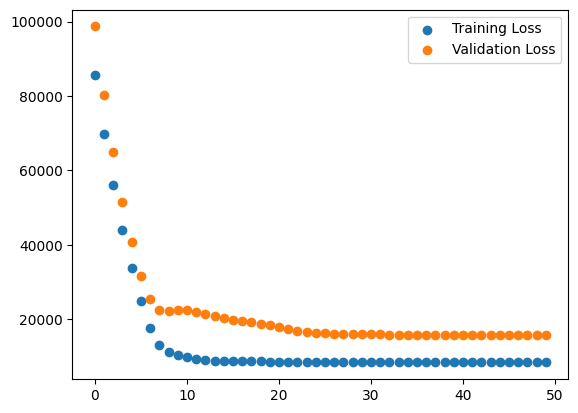

In [248]:
plt.scatter(range(50), training_loss, label='Training Loss')
plt.scatter(range(50), validation_loss, label='Validation Loss')
plt.legend()
plt.show()

In [250]:
epochs = 25
aaa

NameError: name 'aaa' is not defined

In [251]:
def rmsre(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2))

# Initialize Model
input_dim = 2  # Each time step has 2 features
hidden_dim = 32
aux_dim = 14  # Auxiliary features
output_dim = LABELS  # LABELS output
model = RNNWithAuxiliary(input_dim, hidden_dim, aux_dim, output_dim)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dataloader = DataLoader(ConcatDataset([TimeSeriesDataset(X,Y),TimeSeriesDataset(Xv,Yv)]), batch_size=32, collate_fn=collate_fn)
# Training Loop
for epoch in range(epochs):
    model.train()
    for sequences, lengths, aux_data, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(sequences, lengths, aux_data)
        train_loss = criterion(outputs.squeeze(), targets)
        train_loss.backward()
        optimizer.step()

from sklearn.metrics import r2_score
# Evaluation
model.eval()
total_loss = 0.0
total_samples = 0
rmse = 0.0
all_targets = []
all_outputs = []
with torch.no_grad():  # Disable gradient computation
    for sequences, lengths, aux_data, targets in dataloader_v:
        # Forward pass
        outputs = model(sequences, lengths, aux_data)
        eval_loss = criterion(outputs.squeeze(), targets)
        
        # Accumulate loss and sample count
        total_loss += eval_loss.item() * len(targets)
        total_samples += len(targets)
        rmse += torch.sqrt(train_loss) * len(targets)

        # Store outputs and targets for R² calculation
        all_outputs.append(outputs.squeeze().cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Compute average loss
avg_loss = total_loss / total_samples
avg_rmse = rmse / total_samples

# Convert lists of arrays to flattened arrays
all_outputs = np.concatenate([output.flatten() for output in all_outputs], axis=0)
all_targets = np.concatenate([target.flatten() for target in all_targets], axis=0)
# # Compute R2 score
# r2 = r2_score(all_targets, all_outputs)
# # RMSRE
# rrmmssrree = rmsre(all_targets, all_outputs)

# print(f"Avg Loss: {avg_loss:.4f}, Avg RMSE: {avg_rmse:.4f}, RMSRE: {rrmmssrree:.4f}, R² Score: {r2:.4f}")

all_outputs = all_outputs.reshape(-1,LABELS)
all_targets = all_targets.reshape(-1,LABELS)

# Compute R2 score
r2 = r2_score(all_targets[:,1], all_outputs[:,1])
# RMSRE
rrmmssrree = rmsre(all_targets[:,1], all_outputs[:,1])

print(f"RMSRE: {rrmmssrree:.4f}, R² Score: {r2:.4f}")

RMSRE: 0.4465, R² Score: -0.2324


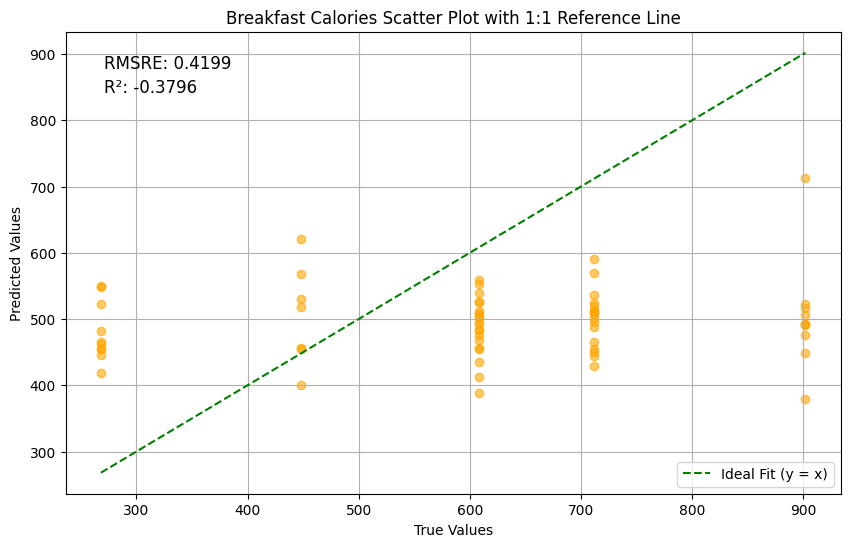

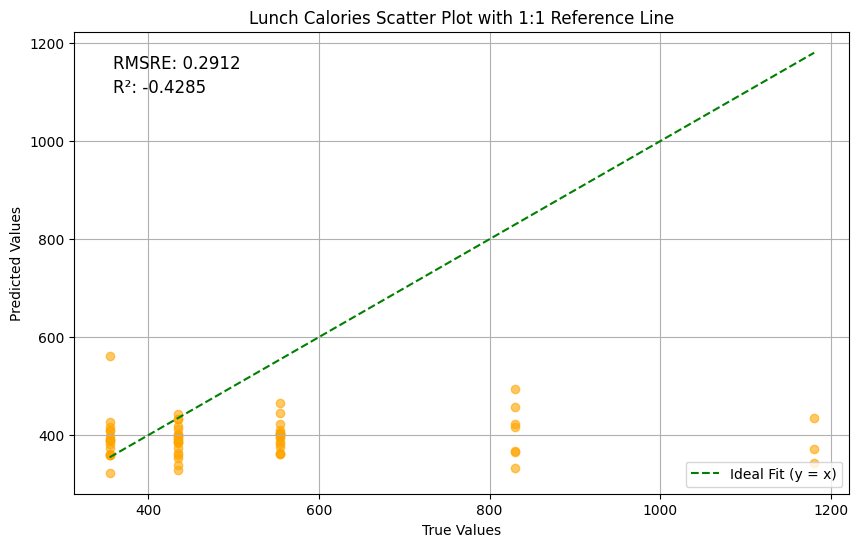

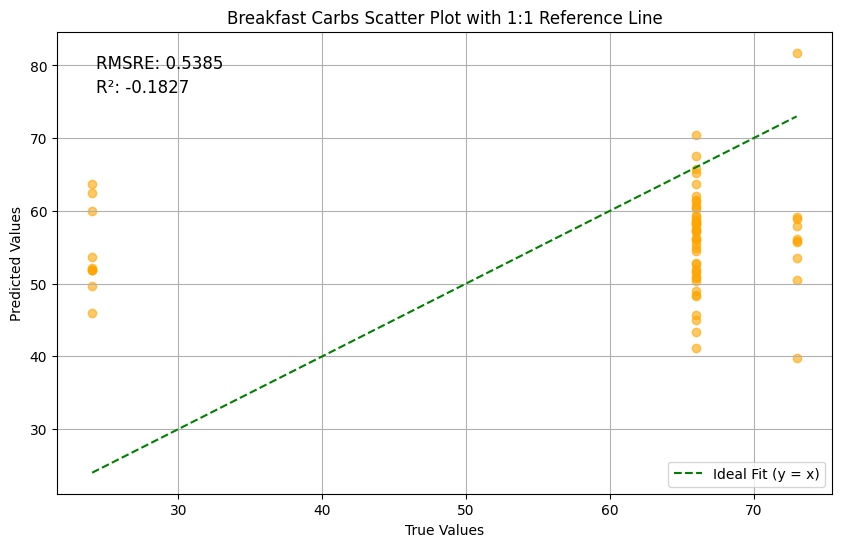

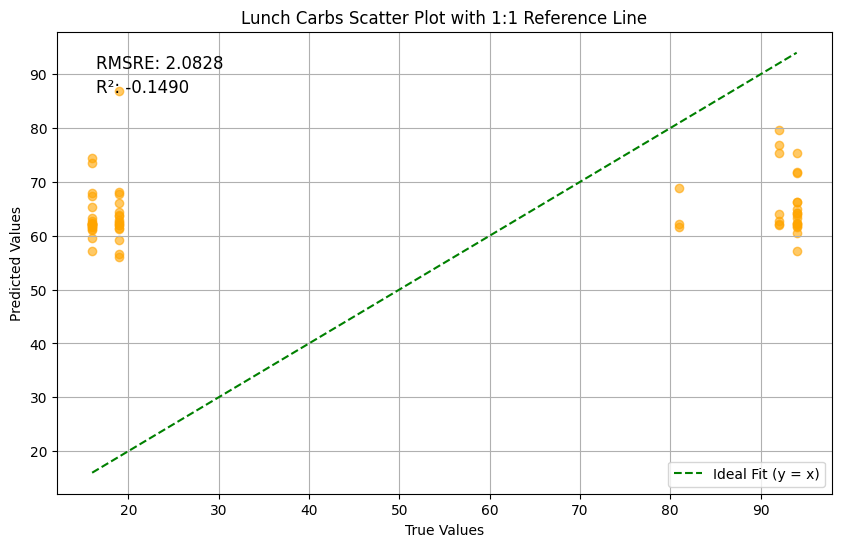

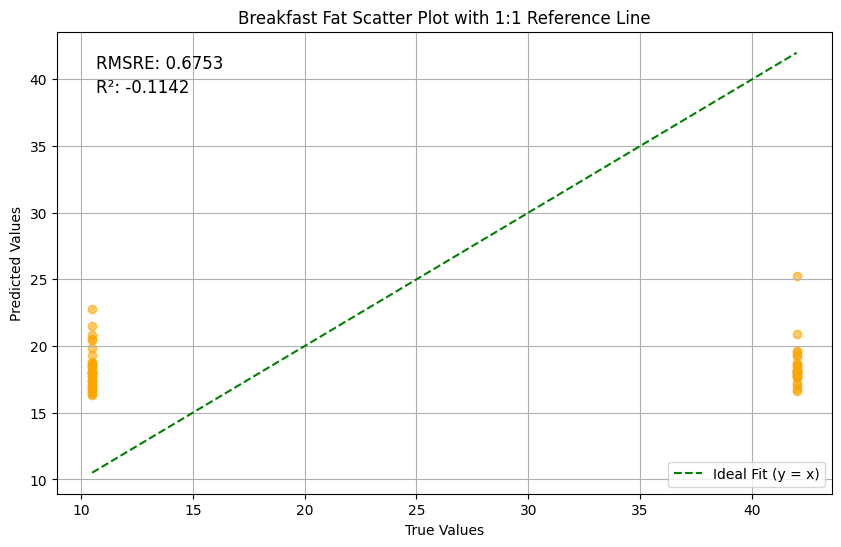

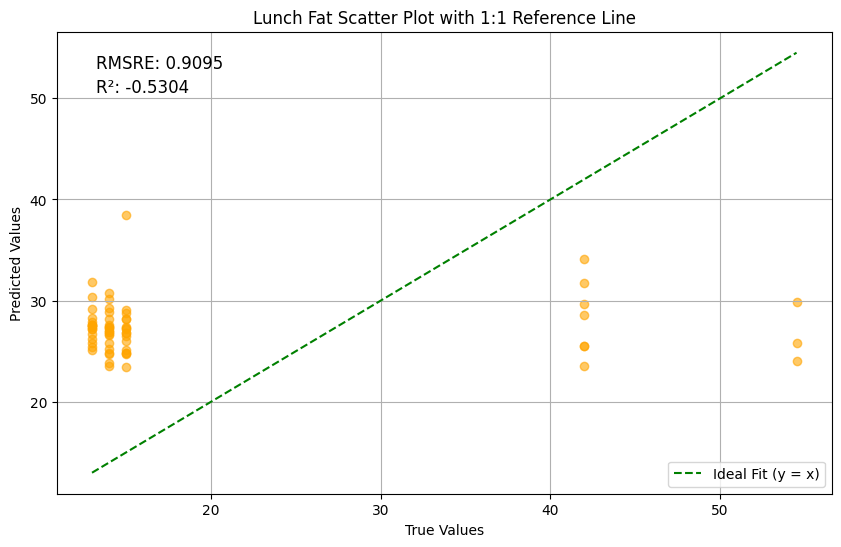

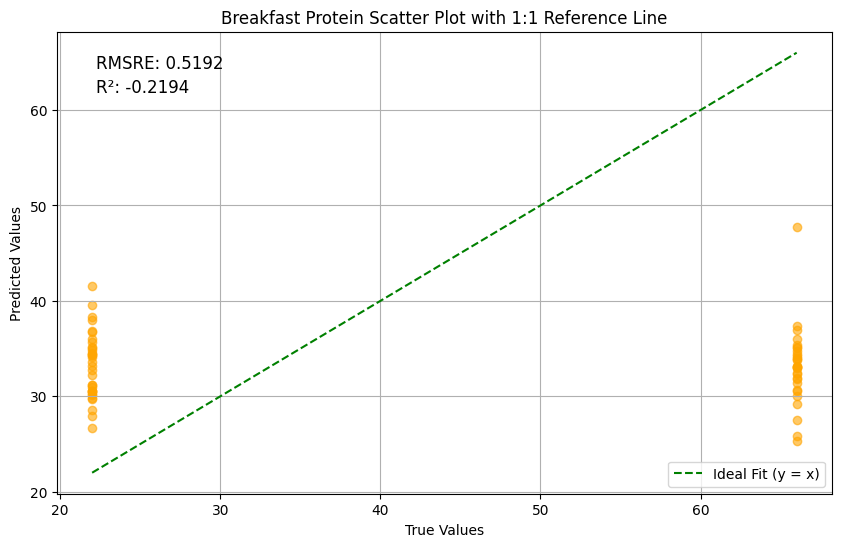

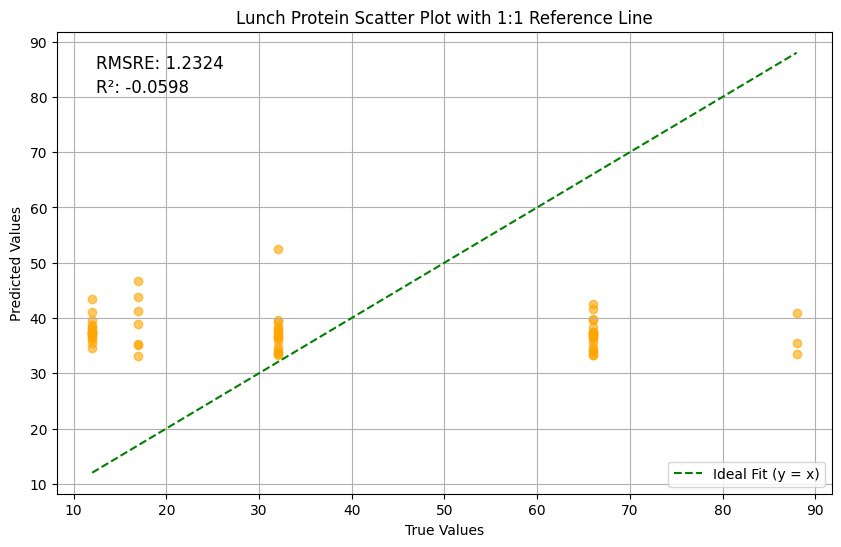

In [ ]:
def plot_regression_curve(y_true, y_pred, best_model_rmsre, best_model_r2, title):
    """
    Plot the regression curve for predicted vs true values and display RMSRE and R².

    Parameters:
    - y_true: The true target values from the training set.
    - y_pred: The predicted target values from the model.
    - best_model_rmsre: RMSRE score of the best model.
    - best_model_r2: R² score of the best model.

    Returns:
    - None: Displays the regression plot.
    """
    # Sort values for a smooth regression line
    plt.figure(figsize=(10, 6))
    # Scatter plot
    plt.scatter(y_true, y_pred, alpha=0.6, color='orange')
    
    # Reference line (y = x)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 
             linestyle='--', color='green', label='Ideal Fit (y = x)')
    
    # Add RMSRE and R² as text annotations
    plt.text(0.05, 0.95, f"RMSRE: {best_model_rmsre:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.text(0.05, 0.90, f"R²: {best_model_r2:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    
    # Add labels, legend, and title
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{title} Scatter Plot with 1:1 Reference Line')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

for i, label in enumerate(L[:LABELS]):
    plot_regression_curve(all_targets[:,i], all_outputs[:,i], rmsre(all_targets[:,i], all_outputs[:,i]), r2_score(all_targets[:,i], all_outputs[:,i]), label)

## This was for checking our model against held out breakfast data
#### Since these results are lackluster, this may not get done.

In [ ]:
# Initialize Model
input_dim = 2  # Each time step has 2 features
hidden_dim = 32
aux_dim = 4  # Auxiliary features
output_dim = LABELS  # Halfed output
model = RNNWithAuxiliary(input_dim, hidden_dim, aux_dim, output_dim)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dataloader = DataLoader(ConcatDataset([TimeSeriesDataset(X,Y),TimeSeriesDataset(Xv,Yv)]), batch_size=32, collate_fn=collate_fn)
dataloader_t = DataLoader(TimeSeriesDataset(Xt,Yt), batch_size=32, collate_fn=collate_fn)
# Training Loop
for epoch in range(epochs):
    model.train()
    for sequences, lengths, aux_data, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(sequences, lengths, aux_data)
        train_loss = criterion(outputs.squeeze(), targets)
        train_loss.backward()
        optimizer.step()

from sklearn.metrics import r2_score
# Evaluation
model.eval()
total_loss = 0.0
total_samples = 0
rmse = 0.0
all_targets = []
all_outputs = []
with torch.no_grad():  # Disable gradient computation
    for sequences, lengths, aux_data, targets in dataloader_t:
        # Forward pass
        outputs = model(sequences, lengths, aux_data)
        # eval_loss = criterion(outputs.squeeze(), targets)
        
        # Accumulate loss and sample count
        # total_loss += eval_loss.item() * len(targets)
        # total_samples += len(targets)
        # rmse += torch.sqrt(train_loss) * len(targets)

        # Store outputs and targets for R² calculation
        all_outputs.append(outputs.squeeze().cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Compute average loss
# avg_loss = total_loss / total_samples
# avg_rmse = rmse / total_samples

# Convert lists of arrays to flattened arrays
all_outputs = np.concatenate([output.flatten() for output in all_outputs], axis=0)
all_targets = np.concatenate([target.flatten() for target in all_targets], axis=0)
# # Compute R2 score
# r2 = r2_score(all_targets, all_outputs)
# # RMSRE
# rrmmssrree = rmsre(all_targets, all_outputs)

# print(f"Avg Loss: {avg_loss:.4f}, Avg RMSE: {avg_rmse:.4f}, RMSRE: {rrmmssrree:.4f}, R² Score: {r2:.4f}")

all_outputs = all_outputs.reshape(-1,int(LABELS/2))
all_targets = all_targets.reshape(-1,int(LABELS/2))
print(all_outputs)
# Compute R2 score
r2 = r2_score(all_targets[:,0], all_outputs[:,0])
# RMSRE
rrmmssrree = rmsre(all_targets[:,0], all_outputs[:,0])

print(f"RMSRE: {rrmmssrree:.4f}, R² Score: {r2:.4f}")

[[548.4261   566.53534   58.113316  58.08312 ]
 [ 20.942081  30.408787  41.695137  41.84134 ]
 [548.053    566.15906   58.06267   58.010708]
 [ 20.93587   30.346104  41.672466  41.760548]
 [502.1588   518.76483   53.180256  53.144787]
 [ 19.159197  27.828754  38.21002   38.286934]
 [498.56287  515.0757    52.771023  52.682125]
 [ 19.041937  27.523663  37.952522  37.879585]
 [503.09482  519.708     53.30547   53.32228 ]
 [ 19.174322  27.983822  38.267353  38.487743]
 [587.3614   607.0971    61.86719   61.026463]
 [ 22.7688    30.974255  44.833508  42.82041 ]
 [534.7532   552.42926   56.64266   56.584957]
 [ 20.425219  29.595867  40.67172   40.72792 ]
 [474.2941   490.89517   49.224224  47.15429 ]
 [ 18.898682  22.273617  36.619534  31.131718]
 [476.46643  493.11697   49.47893   47.456646]
 [ 18.963396  22.488209  36.771214  31.415741]
 [620.04144  641.7779    64.32181   61.36301 ]
 [ 24.876427  28.619083  47.826344  40.09637 ]
 [516.28296  533.9283    54.05132   52.70506 ]
 [ 20.227987 

ValueError: Found input variables with inconsistent numbers of samples: [73, 146]

In [ ]:
all_outputs.shape, all_targets.shape

((146, 4), (73, 4))

In [ ]:
model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():  # Disable gradient computation
    for sequences, lengths, aux_data, targets in dataloader:
        # Forward pass
        outputs = model(sequences, lengths, aux_data)
        
        # Store predictions and targets
        # predictions.append(outputs.cpu().numpy())
        for row in outputs:
            predictions.append(row.numpy())

df = pd.Series(predictions, name=None).to_csv('predictions.csv', index=False, header=False)